In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray
import time
import matplotlib.patches as patches
import glob

import matplotlib.colors as mcolors

from netCDF4 import Dataset
from scipy import stats

from matplotlib.animation import FuncAnimation

import geopandas as gpd
import geocube
from geocube.api.core import make_geocube

path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'


In [9]:
### Plot the height vs. time sections of potential temperature
file = path+'Amazon961x801_201509_201602/wrfinput_d01'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    lats=ds1['XLAT'][0,:,0]
    lons=ds1['XLONG'][0,0,:]
    lu0=ds1['LU_INDEX'][0,:,:]
    
file = path+'Amazon961x801_201509_201602_ILgrassland/wrfinput_d01'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    lu1=ds1['LU_INDEX'][0,:,:]
    
import xarray
path = '/jet/home/xjliu/Amazon_exp/'
year1 = '2015'
year2 = '2016'
file = path+'post_processing/Amazon961x801/T2Q2.'+year1+'09_'+year2+'02.ctrl.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
T0 = ds0['T2']
Q0 = ds0['Q2']

file = path+'post_processing/Amazon961x801/T2Q2.'+year1+'09_'+year2+'02.ILgrassland.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')
T1 = ds1['T2']
Q1 = ds1['Q2']

ok
ok


In [18]:
Q1

<xarray.DataArray 'Q2' (record: 6, Time: 24, south_north: 800, west_east: 960)>
[110592000 values with dtype=float32]
Dimensions without coordinates: record, Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  QV at 2 M
    units:        kg kg-1
    stagger:      
    coordinates:  XLONG XLAT XTIME

## calculate vapor pressure deficit (VPD)
#### VPD = saturation vapor pressure - vapor pressure
####     = saturation vapor pressure * (1-RH)
####    = saturation vapor pressure * (1- mixing ratio / saturation mixing ratio)
         

In [19]:
def VPD(T,Q):
    es = 0.61078*np.exp(17.27*T/(T+237.3)) ## saturation vapor pressure
    ws = 0.622*es/1e5                       ## saturation mixing ratio
    VPD = es*(1-Q/ws)/100                   ## vapor pressure deficit in hPa
    return VPD

VPD0 = VPD(T0,Q0)
VPD1 = VPD(T1,Q1)

#### spatial map of the time-mean (the last 5 months) VPD

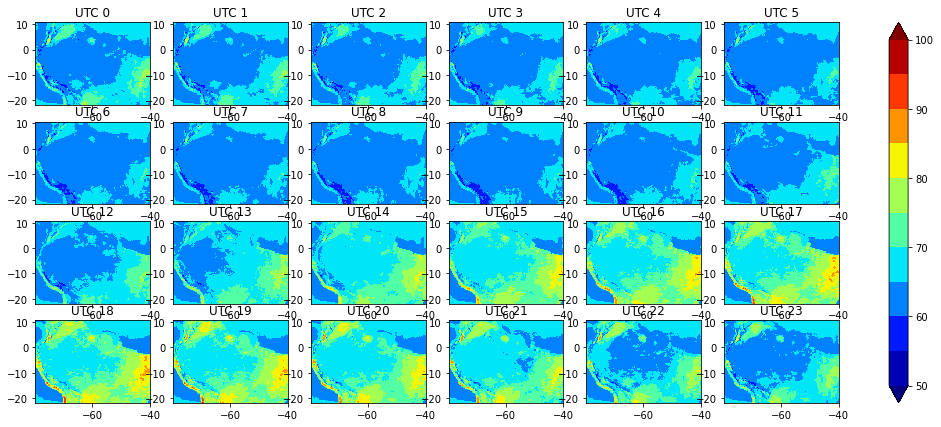

In [10]:
fig, axes = plt.subplots(4,6,figsize=(18,7))
axes = axes.ravel()

for ii in range(24):
    img = axes[ii].contourf(lons,lats,VPD0[1:,ii,:,:].mean(axis=0),cmap='jet',
            levels=np.linspace(50,100,11),
            extend='both')
    axes[ii].set_title('UTC '+str(ii))
fig.colorbar(img,ax=axes[:])

In [21]:
VPD1

<xarray.DataArray (record: 6, Time: 24, south_north: 800, west_east: 960)>
array([[[[66.631744, 66.635574, 66.636116, ..., 64.96774 , 65.00302 ,
          65.028625],
         [66.627594, 66.62648 , 66.628494, ..., 65.00033 , 65.030594,
          65.03206 ],
         [66.62552 , 66.627594, 66.627144, ..., 65.009735, 65.03274 ,
          65.03525 ],
         ...,
         [62.962265, 62.973507, 62.982388, ..., 64.20876 , 64.18288 ,
          64.11396 ],
         [62.96662 , 62.97312 , 62.97294 , ..., 64.18891 , 64.18369 ,
          64.12799 ],
         [62.96855 , 62.95597 , 62.949806, ..., 64.120445, 64.129425,
          64.13788 ]],

        [[66.621284, 66.61978 , 66.61581 , ..., 64.966125, 65.0071  ,
          65.03476 ],
         [66.613396, 66.60977 , 66.60513 , ..., 64.9998  , 65.032135,
          65.04191 ],
         [66.606255, 66.60431 , 66.60065 , ..., 65.00751 , 65.03579 ,
          65.04585 ],
...
         [65.38247 , 65.509995, 65.54511 , ..., 66.75378 , 66.723206,
          66.607574],
         [65.359474, 65.47183 , 65.49116 , ..., 66.728226, 66.72228 ,
          66.61992 ],
         [65.3403  , 65.3537  , 65.36602 , ..., 66.60302 , 66.61834 ,
          66.63086 ]],

        [[66.41163 , 66.39824 , 66.39217 , ..., 63.35719 , 63.352715,
          63.36412 ],
         [66.39911 , 66.34253 , 66.33251 , ..., 63.290844, 63.302002,
          63.360706],
         [66.38577 , 66.313416, 66.28921 , ..., 63.274612, 63.297607,
          63.359013],
         ...,
         [65.30857 , 65.45407 , 65.49347 , ..., 66.7185  , 66.688156,
          66.57996 ],
         [65.294586, 65.42208 , 65.43982 , ..., 66.68657 , 66.68165 ,
          66.58684 ],
         [65.28334 , 65.29268 , 65.30161 , ..., 66.56172 , 66.57836 ,
          66.59322 ]]]], dtype=float32)
Dimensions without coordinates: record, Time, south_north, west_east

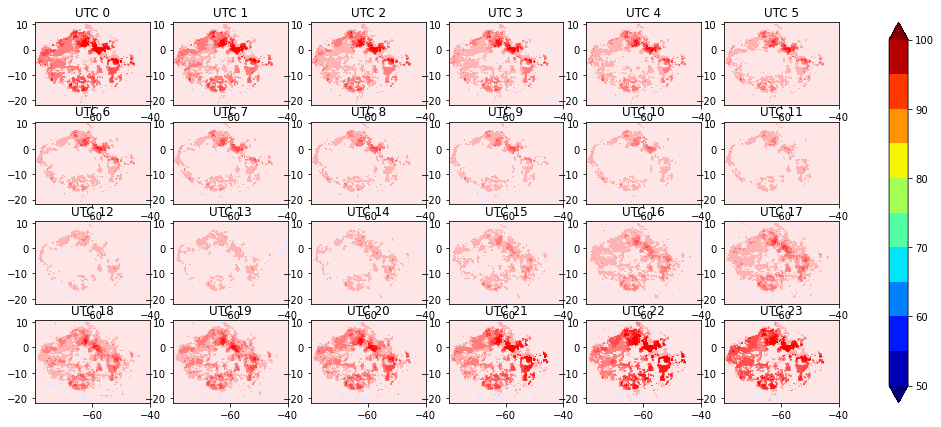

In [22]:
dif_VPD = VPD1-VPD0
fig, axes = plt.subplots(4,6,figsize=(18,7))
axes = axes.ravel()

for ii in range(24):
    axes[ii].contourf(lons,lats,dif_VPD[1:,ii,:,:].mean(axis=0),cmap='bwr',
            levels=np.linspace(-10,10,11),
            extend='both')
    axes[ii].set_title('UTC '+str(ii))
fig.colorbar(img,ax=axes[:])

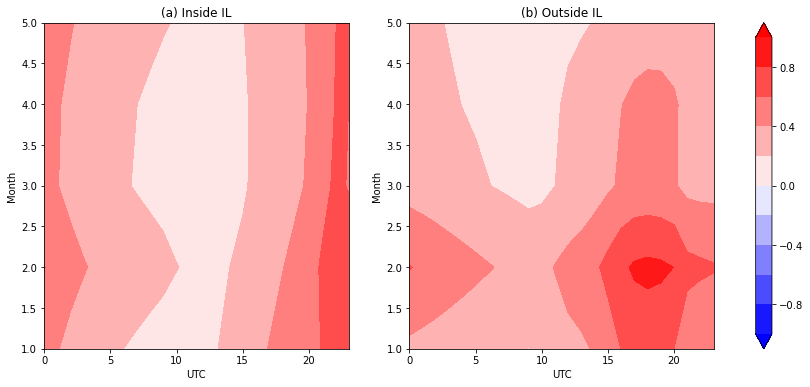

In [23]:
dif_lu = lu1-lu0
dif_VPD = VPD1[:5,:,:]-VPD0[:5,:,:]
dif_VPD_IL = dif_VPD.where(dif_lu>0,np.nan) # Inside IL
dif_VPD_out = dif_VPD.where(dif_lu==0,np.nan) # Inside IL

fig, axes = plt.subplots(1,2,figsize=(15,6))
axes = axes.ravel()
dif_IL_ave = dif_VPD_IL.mean(('south_north','west_east'))
dif_out_ave = dif_VPD_out.mean(('south_north','west_east'))

axes[0].contourf(range(24),range(1,6),dif_IL_ave,cmap='bwr',extend='both',levels=np.linspace(-10,10,11))
im = axes[1].contourf(range(24),range(1,6),dif_out_ave,cmap='bwr',extend='both',levels=np.linspace(-1,1,11))
fig.colorbar(im,ax=axes,orientation='vertical')
axes[0].set_title('(a) Inside IL')
axes[1].set_title('(b) Outside IL')
for ii in range(2):
    axes[ii].set_xlabel('UTC')
    axes[ii].set_ylabel('Month')
